# Week 6: Trees Homework

The goal of this homework is to create a regression model for predicting housing prices (column "median_house_value").  

In this homework we"ll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

## Loading the data

Use only the following columns:  
* `"latitude"`,
* `"longitude"`,
* `"housing_median_age"`,
* `"total_rooms"`,
* `"total_bedrooms"`,
* `"population"`,
* `"households"`,
* `"median_income"`,
* `"median_house_value"`,
* `"ocean_proximity"`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# read data
features = [
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
    "ocean_proximity"
]

df = pd.read_csv("housing.csv", usecols=features)

# fill na
df = df.fillna(0)

# apply log transformation
df["median_house_value"] = np.log1p(df["median_house_value"])

# split data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# extract labels
y_train = df_train["median_house_value"]
y_val = df_val["median_house_value"]
y_test = df_test["median_house_value"]

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

print("split sizes:", len(df_train), len(df_val), len(df_test))

split sizes: 12384 4128 4128


In [2]:
from sklearn.feature_extraction import DictVectorizer

# one hot encoding
df_train_dicts = df_train.to_dict(orient="records")
df_val_dicts = df_val.to_dict(orient="records")
df_test_dicts = df_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
dv.fit(df_train_dicts)

X_train = dv.transform(df_train_dicts)
X_val = dv.transform(df_val_dicts)
X_test = dv.transform(df_test_dicts)

print("features:", dv.get_feature_names_out())

features: ['households' 'housing_median_age' 'latitude' 'longitude' 'median_income'
 'ocean_proximity=<1H OCEAN' 'ocean_proximity=INLAND'
 'ocean_proximity=ISLAND' 'ocean_proximity=NEAR BAY'
 'ocean_proximity=NEAR OCEAN' 'population' 'total_bedrooms' 'total_rooms']


## Question 1

Let"s train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`

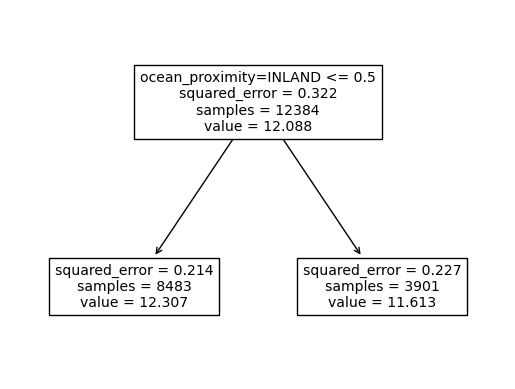

In [3]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

plot_tree(model, feature_names=dv.get_feature_names_out());

In [4]:
from sklearn.tree import export_text

print(export_text(model, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



**Answer**: `ocean_proximity=INLAND`


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85

In [5]:
from sklearn.ensemble import RandomForestRegressor

def compute_rmse(y_true, y_pred):
    return np.sqrt(
        np.mean(
            (y_true - y_pred) ** 2
        )
    )


model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse = compute_rmse(y_val, y_pred)

print(f"{rmse=:.2f}")

rmse=0.25


**Answer**: 0.25

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150

In [6]:
scores = []
for n in range(10, 201, 10):
    model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = compute_rmse(y_val, y_pred)

    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

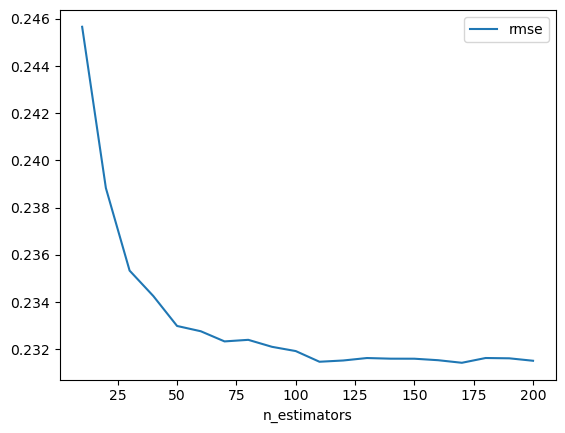

In [7]:
from matplotlib import pyplot as plt

df_scores.plot(x="n_estimators", y="rmse");

**Answer**: It sops inproving roughly about `n_estimators=110`

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [8]:
from itertools import product

max_depth_lst = [10, 15, 20, 25]
scores = []
for max_depth, n_estimators in product(max_depth_lst, range(10, 201, 10)):
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  random_state=1, 
                                  n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = compute_rmse(y_val, y_pred)

    scores.append((max_depth, n_estimators, rmse))


df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "rmse"])

In [9]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.254599
1,10,20,0.252577
2,10,30,0.251463
3,10,40,0.250919
4,10,50,0.250069
...,...,...,...
75,25,160,0.231485
76,25,170,0.231436
77,25,180,0.231552
78,25,190,0.231530


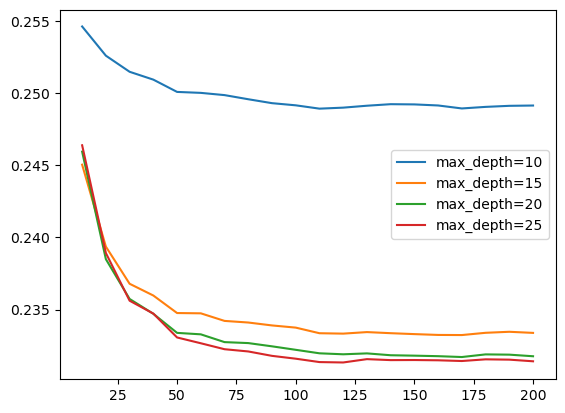

In [10]:
plt.figure()
for d in max_depth_lst:
    df_d = df_scores[df_scores["max_depth"] == d]
    plt.plot(df_d["n_estimators"], df_d["rmse"], label=f"max_depth={d}")
plt.legend()
plt.show()

**Answer:** 25

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [11]:
model = RandomForestRegressor(n_estimators=10, 
                              max_depth=20,
                              random_state=1, 
                              n_jobs=-1)
model.fit(X_train, y_train)


df_importance = pd.DataFrame(zip(dv.get_feature_names_out(), model.feature_importances_),
                             columns=["feature", "importance"])
df_importance.sort_values(by="importance", ascending=False)

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR OCEAN,0.004699


**Answer:** `median_income`

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same


If using a conda environment, install `xgboost` with
```bash
conda install xgboost
```

[0]	train-rmse:8.12733	val-rmse:8.13245
[10]	train-rmse:0.34481	val-rmse:0.35782


/home/lucho/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[20]	train-rmse:0.21580	val-rmse:0.24624
[30]	train-rmse:0.19440	val-rmse:0.23741
[40]	train-rmse:0.17983	val-rmse:0.23419
[50]	train-rmse:0.16934	val-rmse:0.23097
[60]	train-rmse:0.16177	val-rmse:0.22950
[70]	train-rmse:0.15323	val-rmse:0.22787
[80]	train-rmse:0.14564	val-rmse:0.22611
[90]	train-rmse:0.13892	val-rmse:0.22628
[99]	train-rmse:0.13299	val-rmse:0.22610
[0]	train-rmse:10.44371	val-rmse:10.44938
[10]	train-rmse:3.65741	val-rmse:3.66135
[20]	train-rmse:1.30499	val-rmse:1.31054
[30]	train-rmse:0.51144	val-rmse:0.52189
[40]	train-rmse:0.27985	val-rmse:0.30053
[50]	train-rmse:0.22614	val-rmse:0.25334
[60]	train-rmse:0.21035	val-rmse:0.24189
[70]	train-rmse:0.20116	val-rmse:0.23684
[80]	train-rmse:0.19384	val-rmse:0.23398
[90]	train-rmse:0.18794	val-rmse:0.23206
[99]	train-rmse:0.18329	val-rmse:0.23054


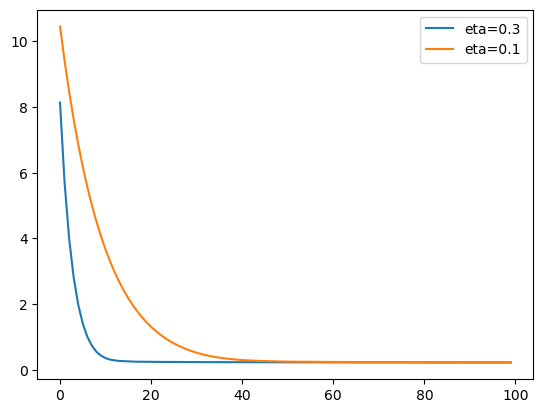

In [12]:
import xgboost as xgb

features = [f.replace("<", "lt ") for f in dv.get_feature_names_out()]
# create matrices
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# create watchlist
watchlist = [(dtrain, "train"), (dval, "val")]

# train
for eta in [0.3, 0.1]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    results = {}
    model = xgb.train(xgb_params, dtrain, 
                      num_boost_round=100,
                      evals=watchlist, 
                      evals_result=results,
                      verbose_eval=10)
    
    plt.plot(results["val"]["rmse"], label=f"eta={eta}")
plt.legend()
plt.show()

**Answer:** Both values of `eta` converge to a similar value but `eta=0.3` reaches it faster